In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zgoubidoo
from zgoubidoo.commands import *
_ = zgoubidoo.ureg

In [176]:
q1 = Quadrupole('QUAD1',
    XL=5 * _.cm,
    B0=0.8 * _.tesla,
    XPAS=1 * _.millimeter,
    XE=0 * _.cm,
    LAM_E=0 * _.mm,
    XS=0 * _.cm,
    LAM_S=0*_.mm,
) 
q2 = Quadrupole('QUAD2',
    XL=10 * _.cm,
    B0=-1.0 * _.tesla,
    XPAS=1 * _.millimeter,
    XE=0 * _.cm,
    LAM_E=0 * _.mm,
    XS=0 * _.cm,
    LAM_S=0*_.mm,
) 
q3 = Quadrupole('QUAD3',
    XL=5 * _.cm,
    B0=0.8 * _.tesla,
    XPAS=1 * _.millimeter,
    XE=0 * _.cm,
    LAM_E=0 * _.mm,
    XS=0 * _.cm,
    LAM_S=0*_.mm,
) 
b1 = Bend('D1',
    XL= 100 * _.mm,
    B1= 2000.0 * _.gauss,
    SK= 0 * _.degree,
    LAM_E= 0 * _.mm,
    LAM_S= 0 * _.mm,
    KPOS=0,
)
b2 = Bend('D2',
    XL= 100 * _.mm,
    B1= 2000.0 * _.gauss,
    SK= 0 * _.degree,
    LAM_E= 0 * _.mm,
    LAM_S= 0 * _.mm,
    KPOS=0,
)

from typing import Iterable, Optional, List
class Sequence:
    def __init__(self, sequence: Optional[Iterable]=None, particle=None):
        self._sequence = sequence
        self._particle = particle or Proton()
        
    def closed_orbit(self, guess: Optional[List]=None, tolerance: float=1e-10):
        zi = zgoubidoo.Input(name='CLOSED_ORBIT_FINDER', line=[
            self._particle, 
            Objet2('BUNCH', BORO=2149 * _.kilogauss * _.cm).add([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]])
        ] + self._sequence)
        objet_index = [i for i, x in enumerate(zi) if isinstance(x, Objet2)][0]
        last_magnet_index = [i for i, x in enumerate(zi) if isinstance(x, Magnet)][-1]
        fit = Fit2(
            PENALTY=tolerance,
            PARAMS = [
                {
                    'IR': objet_index + 1,
                    'IP': 30,  # Y
                    'XC': 0,
                    'DV': [-50, 50],
                },
                {
                    'IR': objet_index + 1,
                    'IP': 31,  # T
                    'XC': 0,
                    'DV': [-50, 50],
                },
                {
                    'IR': objet_index + 1,
                    'IP': 32,  # Z
                    'XC': 0,
                    'DV': [-50, 50],
                },
                {
                    'IR': objet_index + 1,
                    'IP': 33,  # P
                    'XC': 0,
                    'DV': [-50, 50],
                },
            ],
            CONSTRAINTS = [
                {
                    'IC': 3.1,  # F(I, J) - F0(I, J)
                    'I': 1,
                    'J': 2,  # Y
                    'IR': last_magnet_index + 1,
                    'V': 0.0,
                    'WV': 1.0,
                    'NP': 0,
                },
                {
                    'IC': 3.1,  # F(I, J) - F0(I, J)
                    'I': 1,
                    'J': 3,  # T
                    'IR': last_magnet_index + 1,
                    'V': 0.0,
                    'WV': 1.0,
                    'NP': 0,
                },
                {
                    'IC': 3.1,  # F(I, J) - F0(I, J)
                    'I': 1,
                    'J': 4,  # Z
                    'IR': last_magnet_index + 1,
                    'V': 0.0,
                    'WV': 1.0,
                    'NP': 0,
                },
                {
                    'IC': 3.1,  # F(I, J) - F0(I, J)
                    'I': 1,
                    'J': 5,  # P
                    'IR': last_magnet_index + 1,
                    'V': 0.0,
                    'WV': 1.0,
                    'NP': 0,
                }
            ]
        )
        zi.line.append(fit)
        zi.line.append(Marker('END_MARKER'))
        zi.IL = 0
        z = zgoubidoo.Zgoubi()
        out = z(zi)
        co = out.tracks.query("LABEL1 == 'END_MARKER'").iloc[0][['Yo', 'To', 'Zo', 'Po', 'Do-1']].values
        co1 = out.tracks.query("LABEL1 == 'END_MARKER'").iloc[0][['Y-DY', 'T', 'Z', 'P', 'D-1']].values
        assert((co-co1).all() < tolerance)
        self._co = co
        zi = zgoubidoo.Input(name='TEST', line=[
            self._particle, 
            Objet2('BUNCH', BORO=2149 * _.kilogauss * _.cm).add([[100*co[0], 1000*co[1], 100*co[2], 1000*co[3], 0.0, co[4]+1, 0.0]])
        ] + self._sequence)
        zi.IL = 2
        out = z(zi)
        self._zi = zi
        return out

s = Sequence([q1, b1, q2, b2, q3])
out = s.closed_orbit()

In [177]:
out.results[0]['result']

['TEST',
 " 'PARTICUL' PROTON                                                                                            1",
 '9.382720300000e+02 1.602176487000e-19 1.792847350500e+00 0.000000000000e+00 0.0',
 ' ',
 ' ',
 ' ',
 " 'OBJET' BUNCH                                                                                                2",
 '2.149000000000e+03',
 '2.00',
 '1 1',
 '-9.12104623 4.14062564e-05 7.528436870000001e-06 -0.0004892749080000001 0.0 1.0 A',
 '0',
 ' ',
 ' ',
 " 'QUADRUPO' QUAD1                                                                                             3",
 '2',
 '5.000000000000e+00 1.000000000000e+00 8.000000000000e+00',
 '0.000000000000e+00 0.000000000000e+00',
 '6 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00',
 '0.000000000000e+00 0.000000000000e+00',
 '6 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00',
 '0.1'

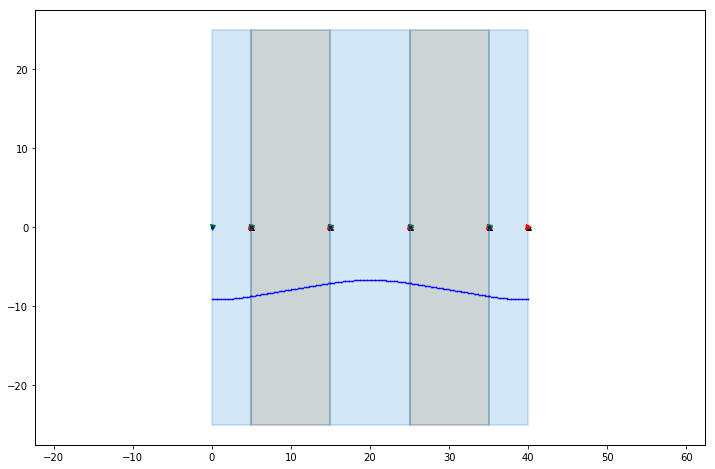

In [178]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

zmpl = zgoubidoo.vis.ZgoubiMpl(ax, with_frames=True, with_boxes=True, with_drifts=True)
tracks = zgoubidoo.read_plt_file()
line = zgoubidoo.survey(beamline=s._zi, reference_frame=Frame())
zgoubidoo.vis.plot(beamline=line, 
                        artist=zmpl, 
                        tracks=tracks, 
                        )
ax.set_aspect('equal', 'datalim')

In [151]:
s._zi[Fit2]

TEST_filtered_by_Fit2
        'END' 02f865f768 
        

In [81]:
s._zi[Fit2][0].output

['      8  Keyword, label(s) :  FIT2        3dda2b8bb3            ',
 '     FIT procedure launched. Method is 2',
 '           variable #            1       IR =            2 ,   ok.',
 '           variable #            1       IP =           30 ,   ok.',
 '           variable #            2       IR =            2 ,   ok.',
 '           variable #            2       IP =           31 ,   ok.',
 '           variable #            3       IR =            2 ,   ok.',
 '           variable #            3       IP =           32 ,   ok.',
 '           variable #            4       IR =            2 ,   ok.',
 '           variable #            4       IP =           33 ,   ok.',
 '           constraint #            1       IR =            7 ,   ok.',
 '           constraint #            1       I  =            1 ,   ok.',
 '           constraint #            2       IR =            7 ,   ok.',
 '           constraint #            2       I  =            1 ,   ok.',
 '           constraint # 

In [68]:
print('\n'.join(out.results[0]['result']))

TEST
 'PARTICUL' PROTON                                                                                            1
9.382720300000e+02 1.602176487000e-19 1.792847350500e+00 0.000000000000e+00 0.0
 
 
 
 'OBJET' BUNCH                                                                                                2
2.149000000000e+03
2.00
1 1
0.0 0.0 0.0 0.0 0.0 0.5 A
0
 
 
 'QUADRUPO' QUAD1                                                                                             3
2
5.000000000000e+00 1.000000000000e+00 8.000000000000e+00
0.000000000000e+00 0.000000000000e+00
6 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00
0.000000000000e+00 0.000000000000e+00
6 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00
0.1
1 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00
 
 
 'BEND' D1                                                                     

In [ ]:
fit = Fit2(
    PENALTY=1e-12,
    PARAMS = [
        {
            'IR': 1,
            'IP': 30,
            'XC': 0,
            'DV': [-10, 10],
        },
        {
            'IR': 1,
            'IP': 31,
            'XC': 0,
            'DV': 4.0,
        },
        {
            'IR': 1,
            'IP': 32,
            'XC': 0,
            'DV': 4.0,
        },
        {
            'IR': 1,
            'IP': 33,
            'XC': 0,
            'DV': 4.0,
        },
    ],
    CONSTRAINTS = [
        {
            'IC': 3.1,
            'I': 1,
            'J': 2,
            'IR': 7,
            'V': 0.0,
            'WV': 1.0,
            'NP': 0,
        },
        {
            'IC': 3.1,
            'I': 1,
            'J': 3,
            'IR': 7,
            'V': 0.0,
            'WV': 1.0,
            'NP': 0,
        },
        {
            'IC': 3.1,
            'I': 1,
            'J': 4,
            'IR': 7,
            'V': 0.0,
            'WV': 1.0,
            'NP': 0,
        },
        {
            'IC': 3.1,
            'I': 1,
            'J': 5,
            'IR': 7,
            'V': 0.0,
            'WV': 1.0,
            'NP': 0,
        }
    ]
)
#di += fit
di.XPAS = 1 * _.mm

z = zgoubidoo.Zgoubi()
out = z(di)
print('\n'.join(out.results[0]['result']))